# Preliminaries

In [1]:
import subprocess

In [2]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/sars/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

## Paths

In [3]:
import os
import pathlib
import sys

In [4]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks))
    sys.path.append(parent)


<br>

## Libraries

In [5]:
%matplotlib inline

In [6]:
import arviz as az
import graphviz
import dotmap
import pymc3 as pm

import logging

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import collections

<br>

**Custom**

In [7]:
import sars.graphics.settings
import sars.graphics.relational

In [8]:
import sars.capita.feed.data
import sars.capita.feed.segmentation

<br>

## Set-up

**Display**<br>
If the display screen supports **retina display**, a figure's resolution can be enhanced via


In [9]:
%config InlineBackend.figure_format = 'retina'

<br>

**Jupyter Settings**

In [10]:
settings = sars.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

**Relational Graph Labels**

In [11]:
RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

## Logging

In [12]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data

## Read

In [13]:
data = sars.capita.feed.data.Data().read()
logger.info('\n{}\n'.format(data.head()))

INFO:__main__:
  datetimeobject STUSPS  deathRate  positiveRate  testRate  icuRate  \
0     2020-01-22     AK        0.0           0.0       0.0      0.0   
1     2020-01-23     AK        0.0           0.0       0.0      0.0   
2     2020-01-24     AK        0.0           0.0       0.0      0.0   
3     2020-01-25     AK        0.0           0.0       0.0      0.0   
4     2020-01-26     AK        0.0           0.0       0.0      0.0   

   hospitalizedRate  ndays  
0               0.0      0  
1               0.0      1  
2               0.0      2  
3               0.0      3  
4               0.0      4  



<br>
<br>

## In Focus

In [14]:
stusps = 'ND'

In [36]:
ahead = 25

<br>

**Hence**

In [15]:
segmentation = sars.capita.feed.segmentation.Segmentation(data=data)

features, observations, frame = segmentation.exc(
    stusps=stusps, independent=['ndays'], dependent=['positiveRate', 'hospitalizedRate', 'deathRate'])

logger.info('The shape & type of features\n{}, {}\n'.format(features.shape, type(features)))
logger.info('The shape & type of observations\n{}, {}\n'.format(observations.shape, type(observations)))
logger.info('The frame\n{}, {}\n'.format(frame.shape, type(frame)))

INFO:__main__:The shape & type of features
(260, 1), <class 'numpy.ndarray'>

INFO:__main__:The shape & type of observations
(260, 3), <class 'numpy.ndarray'>

INFO:__main__:The frame
(260, 4), <class 'pandas.core.frame.DataFrame'>



<br>

**And for forecasting**

In [16]:
futures = segmentation.futures(features=features, steps=np.array([1]), ahead=ahead)

logger.info('The shape of futures\n{}\n'.format(futures.shape))

INFO:__main__:The shape of futures
(285, 1)



<br>

**An illustration of the independent & dependent variables**

In [17]:
import sars.capita.models.covariates.graphs

In [18]:
graphs = sars.capita.models.covariates.graphs.Graphs()

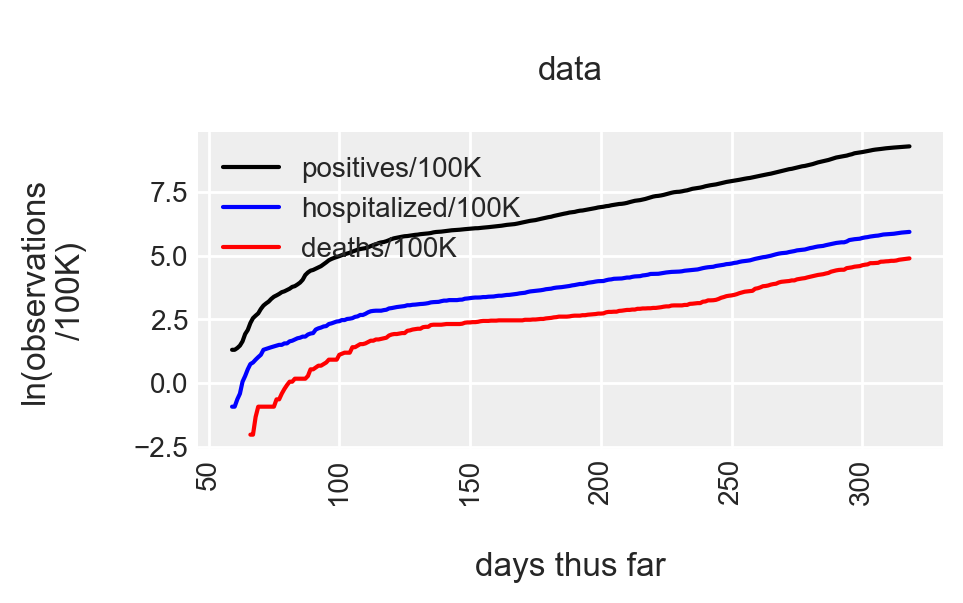

In [19]:
ax = graphs.baseline(
    data=frame, labels=RelationalGraphLabels._make(['\ndata\n', '\ndays thus far', 'ln(observations\n/100K)\n'])
)
ax.legend(loc='upper left', fontsize='small');

<br>
<br>

# Inference

## Structures

Preparing data structures for the inference model

In [20]:
import sars.capita.models.covariates.structures

In [21]:
structures = sars.capita.models.covariates.structures.Structures()

<br>

**Scaling Objects & Structures** of the:

* Independent Variable/s

In [22]:
XSCALER, XSCALED = structures.exc(tensor=features)

logger.info('\nThe shape & type of the scaled features: {}, {}.\n'.
       format(XSCALED.shape, type(XSCALED)))


INFO:__main__:
The shape & type of the scaled features: (260, 1), <class 'numpy.ndarray'>.



<br>

* Dependent Variable/s

In [23]:
YSCALER, YSCALED = structures.exc(tensor=observations)

logger.info('\nThe shape & type of the scaled observations: {}, {}.\n'.
       format(YSCALED.shape, type(YSCALED)))


INFO:__main__:
The shape & type of the scaled observations: (260, 3), <class 'numpy.ndarray'>.



<br>
<br>

## Model

**Attributes**

In [24]:
import sars.capita.models.covariates.attributes

In [25]:
sections_ = XSCALED.shape[0]
instances_ = np.ones(shape=XSCALED.shape[0], dtype=int)

attributes = sars.capita.models.covariates.attributes.Attributes(
    independent=XSCALED, dependent=YSCALED, sections_=sections_, instances_=instances_)

<br>

Hence

In [26]:
measures = attributes.measures()
sections = attributes.sections()

logger.info('\n# of records: {N}, # of independent variables: {M}, # of dependent variables: {P}\n'.\
            format(N = measures.N, M = measures.M, P = measures.P))

logger.info('\n# of sections: {sections_}\n'.format(sections_ = sections.sections_))

INFO:__main__:
# of records: 260, # of independent variables: 1, # of dependent variables: 3

INFO:__main__:
# of sections: 260



<br>

**Inference**

In [27]:
import sars.capita.models.covariates.inference

In [28]:
inference = sars.capita.models.covariates.inference.Inference(
    independent=XSCALED, dependent=YSCALED, measures=measures, sections=sections)

In [29]:
model, likelihood, trace, maximal, arviztrace = inference.exc()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]
INFO:pymc3:NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5948 seconds.
INFO:pymc3:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5948 seconds.
There were 1062 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1062 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7930852601542817, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1153 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1153 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some p


INFO:pymc3:


<br>

**DAG**

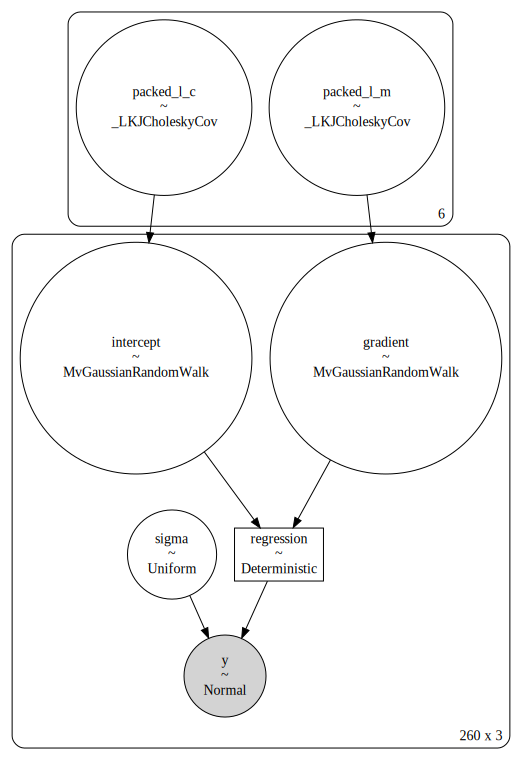

In [32]:
# The DAG
diagram = pm.model_graph.ModelGraph(model=model).make_graph()
diagram.node_attr.update(shape='circle')

# Diagrams
diagram.save('model.gv')
graphviz.render(engine='dot', format='pdf', filepath='model.gv')

graphviz.Source.from_file(filename='model.gv')

<br>
<br>

## Trace

In [30]:
trace.varnames

['packed_l_c_cholesky-cov-packed__',
 'intercept',
 'packed_l_m_cholesky-cov-packed__',
 'gradient',
 'sigma_interval__',
 'packed_l_c',
 'packed_l_m',
 'regression',
 'sigma']

In [35]:
samplings = trace.report.n_draws * trace.nchains
logger.info('The number of sampled instances\n{}\n'.format(samplings))

INFO:__main__:The number of sampled instances
4000



<br>
<br>

## Estimates

In [37]:
import sars.capita.models.covariates.estimates

In [39]:
estimates = sars.capita.models.covariates.estimates.Estimates(trace=trace, ahead=ahead, samplings=samplings, measures=measures)

<br>

**Intercepts & Gradients**

In [41]:
Parameter = collections.namedtuple(typename='Parameter', field_names=['name', 'cholesky'])

intercepts_ = estimates.exc(parameter=Parameter._make(('intercept', 'packed_l_c')))
gradients_ = estimates.exc(parameter=Parameter._make(('gradient', 'packed_l_m')))

logger.info('\n{}\n'.format(intercepts_.shape))
logger.info('\n{}\n'.format(gradients_.shape))

INFO:__main__:
(4000, 285, 3)

INFO:__main__:
(4000, 285, 3)



<br>
<br>

## Predictions

In [42]:
import sars.capita.models.covariates.predictions

In [43]:
predictions = sars.capita.models.covariates.predictions.Predictions(
    intercepts_=intercepts_, gradients_=gradients_, futures=futures, samplings=samplings, 
    xscaler=XSCALER, yscaler=YSCALER, measures=measures)

In [44]:
line = predictions.line()
lines = predictions.lines(size=100)

logger.info('\n{}\n'.format(line.shape))
logger.info('\n{}\n'.format(lines.shape))

INFO:__main__:
(285, 3)

INFO:__main__:
(100, 285, 3)



<br>
<br>

# Illustrate